<h1 style="text-align:center">Rain in Australia<h1>

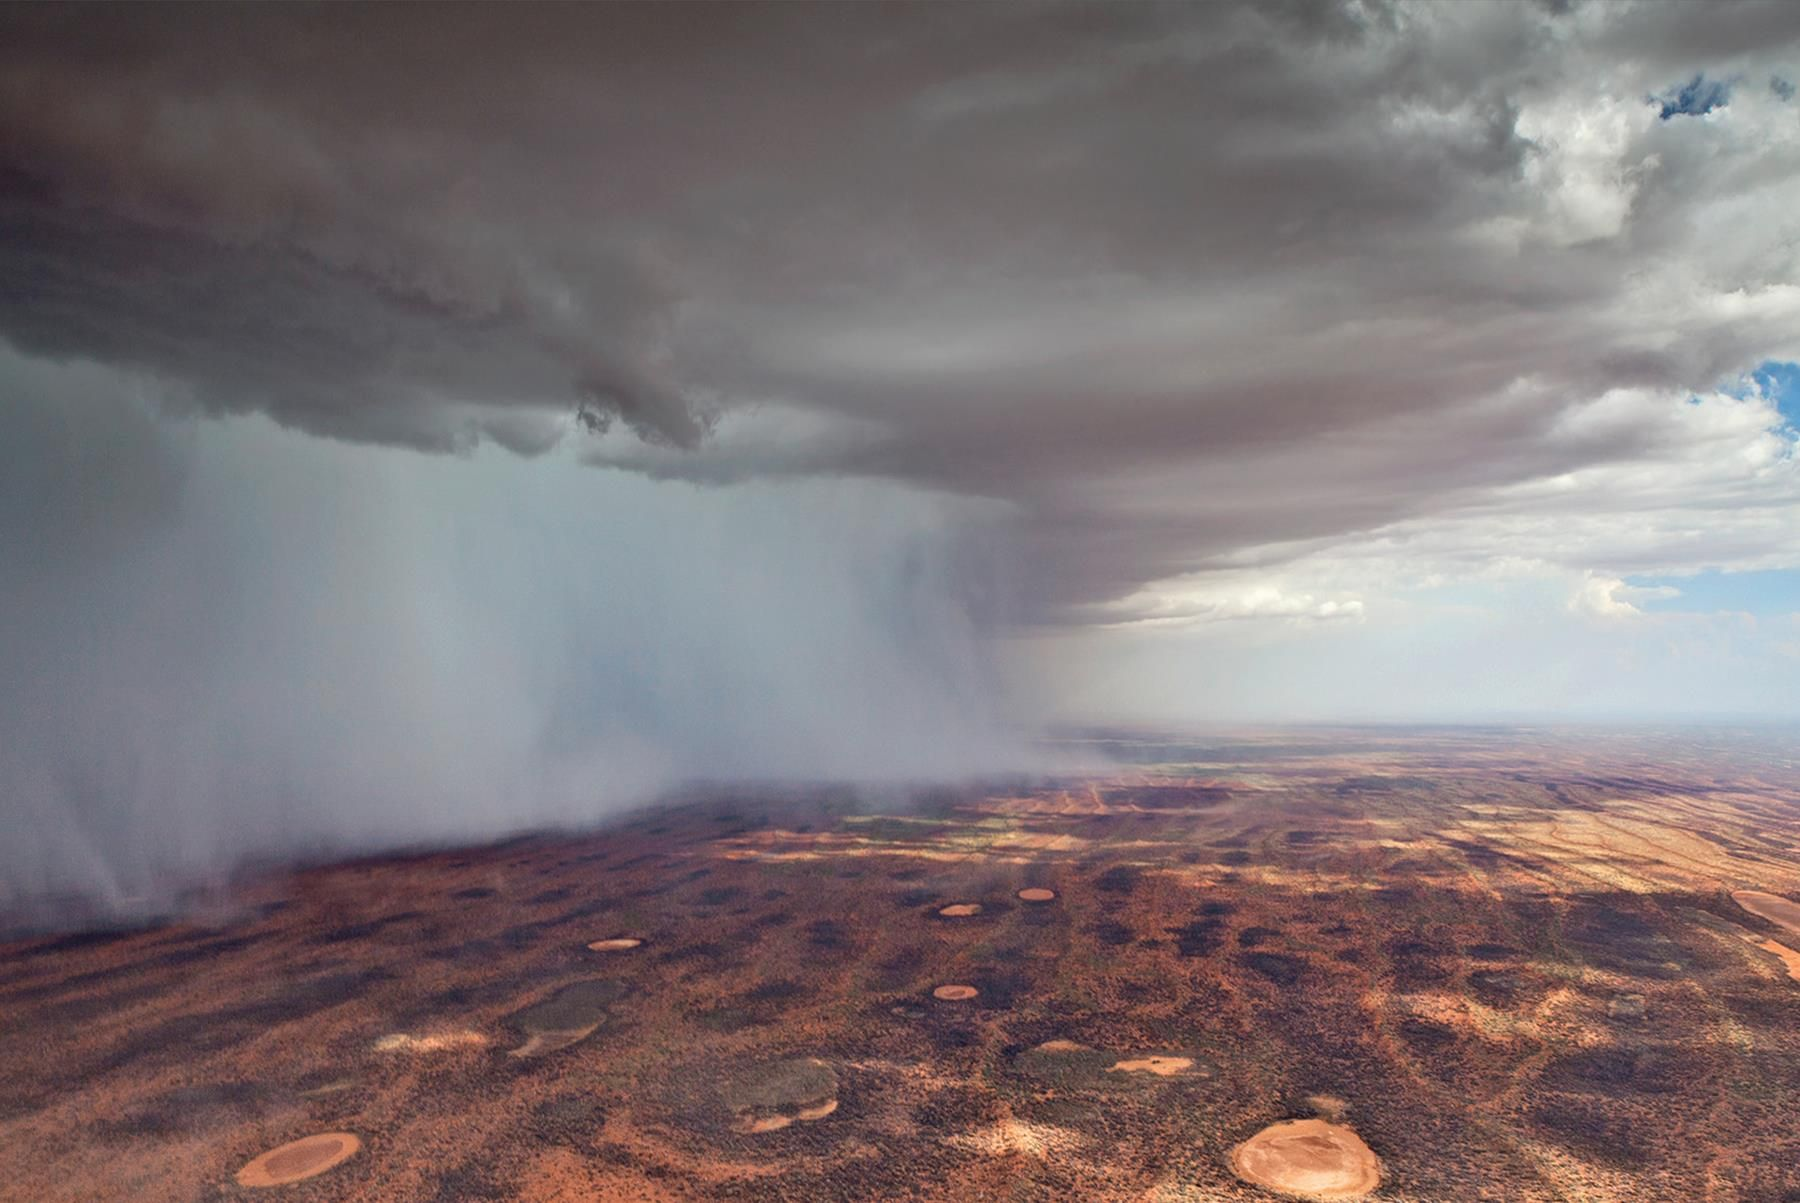

### Context
Predict next-day rain by training classification models on the target variable RainTomorrow.

### Content
This dataset contains about 10 years of daily weather observations from many locations across Australia.

* RainTomorrow is the target variable to predict. Did it rain the next day, Yes or No? 
* RainTomorrow column is Yes if the rain for that day was 1mm or more.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
import folium

In [2]:
df = pd.read_csv('data/weatherAUS.csv')

In [3]:
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

In [4]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [6]:
def display_col_info(df):
    zeros_cnt = df.isnull().sum().sort_values(ascending=True)
    zero_count = df.isnull().sum() / df.isnull().count()
    percent_zeros = (zero_count).sort_values(ascending=False)
    missing_data = pd.concat([zeros_cnt, percent_zeros],
                             axis=1,
                             keys=['Total', 'Percent'])
    print(missing_data)

In [7]:
display_col_info(df)

               Total   Percent
Date               0  0.000000
Location           0  0.000000
MaxTemp         1261  0.008669
MinTemp         1485  0.010209
Temp9am         1767  0.012148
WindSpeed9am    1767  0.012148
Humidity9am     2654  0.018246
WindSpeed3pm    3062  0.021050
Rainfall        3261  0.022419
RainToday       3261  0.022419
RainTomorrow    3267  0.022460
Temp3pm         3609  0.024811
WindDir3pm      4228  0.029066
Humidity3pm     4507  0.030984
WindGustSpeed  10263  0.070555
WindGustDir    10326  0.070989
WindDir9am     10566  0.072639
Pressure3pm    15028  0.103314
Pressure9am    15065  0.103568
Cloud9am       55888  0.384216
Cloud3pm       59358  0.408071
Evaporation    62790  0.431665
Sunshine       69835  0.480098


In [8]:
unq_vals = pd.DataFrame()
cols = []
unique_count = []
for col in df.columns:
    unique_count.append(df[col].nunique())
    cols.append(col)

unq_vals["columns"] = cols
unq_vals["unique_count"] = unique_count
unq_vals

columns  unique_count
0            Date          3436
1        Location            49
2         MinTemp           389
3         MaxTemp           505
4        Rainfall           681
5     Evaporation           358
6        Sunshine           145
7     WindGustDir            16
8   WindGustSpeed            67
9      WindDir9am            16
10     WindDir3pm            16
11   WindSpeed9am            43
12   WindSpeed3pm            44
13    Humidity9am           101
14    Humidity3pm           101
15    Pressure9am           546
16    Pressure3pm           549
17       Cloud9am            10
18       Cloud3pm            10
19        Temp9am           441
20        Temp3pm           502
21      RainToday             2
22   RainTomorrow             2

## Data Preprocessing

#### Handling Categorical Columns

In [9]:
category_obj = (df.dtypes == "object")
category_cols = list(category_obj[category_obj].index)
print(f"Categorical Columns: {category_cols}")

Categorical Columns: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [10]:
for col in category_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

#### Handling Numerical Columns

In [11]:
num_types = (df.dtypes == "float64")
num_cols = list(num_types[num_types].index)
print(f"Numerical Columns:\n{num_cols}")

Numerical Columns:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [12]:
for col in num_cols:
    df[col].fillna(df[col].mean(), inplace=True)

In [13]:
display_col_info(df)

               Total  Percent
Date               0      0.0
Temp3pm            0      0.0
Temp9am            0      0.0
Cloud3pm           0      0.0
Cloud9am           0      0.0
Pressure3pm        0      0.0
Pressure9am        0      0.0
Humidity3pm        0      0.0
Humidity9am        0      0.0
WindSpeed3pm       0      0.0
RainToday          0      0.0
WindSpeed9am       0      0.0
WindDir9am         0      0.0
WindGustSpeed      0      0.0
WindGustDir        0      0.0
Sunshine           0      0.0
Evaporation        0      0.0
Rainfall           0      0.0
MaxTemp            0      0.0
MinTemp            0      0.0
Location           0      0.0
WindDir3pm         0      0.0
RainTomorrow       0      0.0


In [14]:
df.head(5)

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6     5.468232  7.611178   
1  2008-12-02   Albury      7.4     25.1       0.0     5.468232  7.611178   
2  2008-12-03   Albury     12.9     25.7       0.0     5.468232  7.611178   
3  2008-12-04   Albury      9.2     28.0       0.0     5.468232  7.611178   
4  2008-12-05   Albury     17.5     32.3       1.0     5.468232  7.611178   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1  8.000000   4.50993     16.9     21.8         No   
1       1010.6       1007.8  4.447461   4.50993     17.2     24.3         No   
2       1007.6       1008.7  4.447461   2.00000     21.0     23.2         No   
3       1017.6       1012.8  4.447461   4.50993     18.1     26.5         No   
4       1010.8       1006.0  7.000000   8.00000     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

In [15]:
aus_df = df.copy(deep=True)

In [16]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [17]:
df['Date'] = pd.to_datetime(df['Date'])

In [18]:
df['Location'] = pd.Categorical(df['Location'])
df['WindGustDir'] = pd.Categorical(df['WindGustDir'])
df['WindDir9am'] = pd.Categorical(df['WindDir9am'])
df['RainToday'] = pd.Categorical(df['RainToday'])
df['RainTomorrow'] = pd.Categorical(df['RainTomorrow'])

In [19]:
labelencoder = LabelEncoder()
df['Location_cat'] = labelencoder.fit_transform(df['Location'])

In [20]:
labelencoder = LabelEncoder()
df['WindGustDir_cat'] = labelencoder.fit_transform(df['WindGustDir'])

In [21]:
labelencoder = LabelEncoder()
df['WindDir9am_cat'] = labelencoder.fit_transform(df['WindDir9am'])

In [22]:
labelencoder = LabelEncoder()
df['RainToday_cat'] = labelencoder.fit_transform(df['RainToday'])

In [23]:
labelencoder = LabelEncoder()
df['RainTomorrow_cat'] = labelencoder.fit_transform(df['RainTomorrow'])

In [24]:
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0 2008-12-01   Albury     13.4     22.9       0.6     5.468232  7.611178   
1 2008-12-02   Albury      7.4     25.1       0.0     5.468232  7.611178   
2 2008-12-03   Albury     12.9     25.7       0.0     5.468232  7.611178   
3 2008-12-04   Albury      9.2     28.0       0.0     5.468232  7.611178   
4 2008-12-05   Albury     17.5     32.3       1.0     5.468232  7.611178   

  WindGustDir  WindGustSpeed WindDir9am  ... Cloud3pm  Temp9am  Temp3pm  \
0           W           44.0          W  ...  4.50993     16.9     21.8   
1         WNW           44.0        NNW  ...  4.50993     17.2     24.3   
2         WSW           46.0          W  ...  2.00000     21.0     23.2   
3          NE           24.0         SE  ...  4.50993     18.1     26.5   
4           W           41.0        ENE  ...  8.00000     17.8     29.7   

   RainToday  RainTomorrow  Location_cat  WindGustDir_cat  WindDir9am_cat  \
0         No            No             2               13              13   
1         No            No             2               14               6   
2         No            No             2               15              13   
3         No            No             2                4               9   
4         No            No             2               13               1   

   RainToday_cat  RainTomorrow_cat  
0              0                 0  
1              0                 0  
2              0                 0  
3              0                 0  
4              0                 0  

[5 rows x 28 columns]

## Data Visualizations

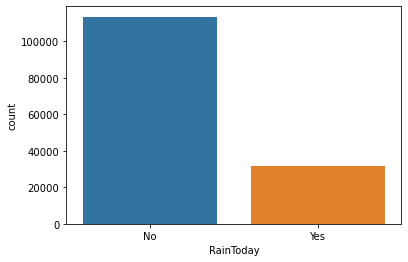

In [25]:
sns.countplot(data=df, x="RainToday")
plt.show()

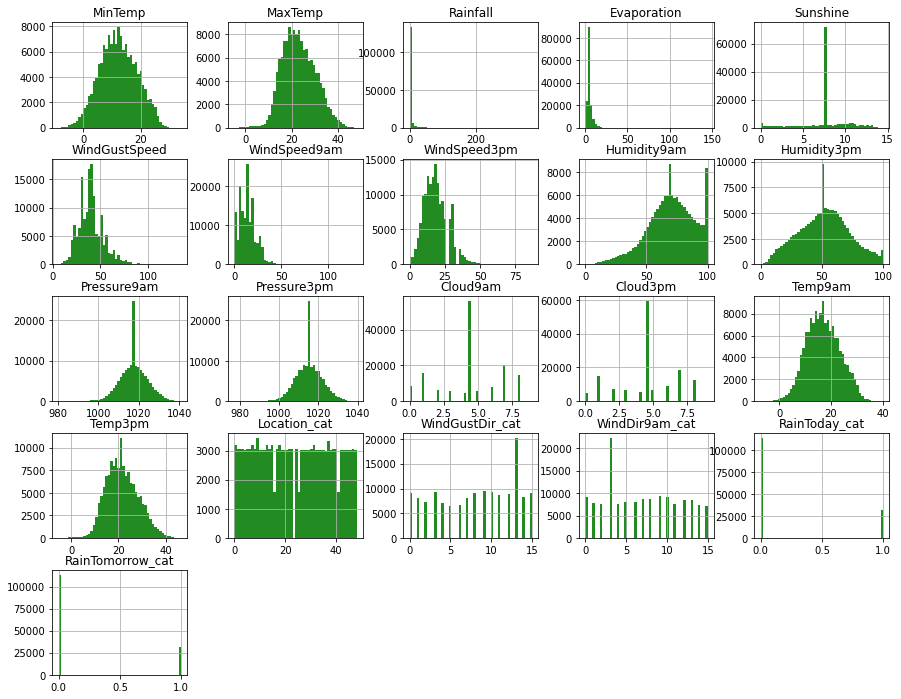

In [26]:
df.hist(bins=50, figsize=(15, 12), color='forestgreen')
plt.show()

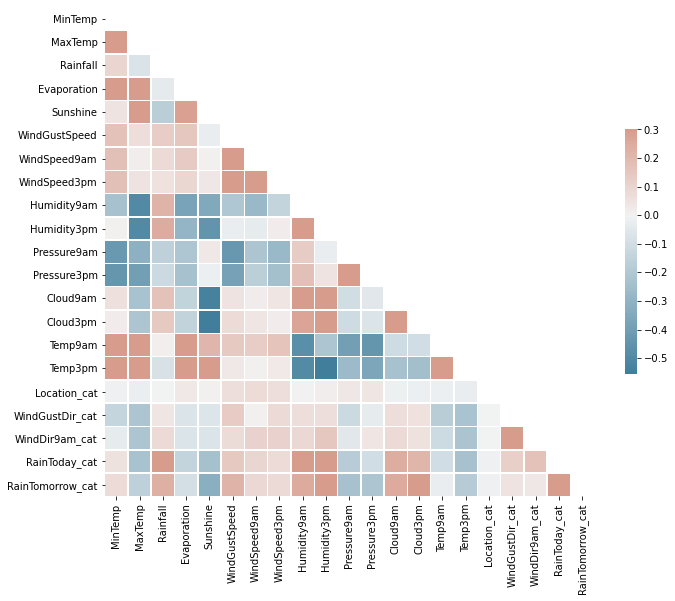

In [27]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=.3,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})
plt.show()

In [28]:
loc_max_temp = df[["Location", "MaxTemp"]].groupby("Location").mean()
loc_max_temp.sort_values(by="MaxTemp", inplace=True)
labels = {"MaxTemp": "Maximum Temperature °C", "Location": "Location Names"}
fig = px.bar(loc_max_temp, labels=labels, color_discrete_sequence=['indianred'])
fig.show()

In [29]:
loc_min_temp = df[["Location", "MinTemp"]].groupby("Location").mean()
loc_min_temp.sort_values(by="MinTemp", inplace=True)
labels = {"MinTemp": "Minumum Temperature °C", "Location": "Location Names"}
fig = px.bar(loc_min_temp,
             labels=labels,
             color_discrete_sequence=['seagreen'])
fig.show()

In [30]:
loc_rain = df[["Location", "Rainfall"]].groupby("Location").mean()
loc_rain.sort_values(by="Rainfall", inplace=True)
labels = {"Rainfall": "Amount of Rainfall", "Location": "Location Names"}
fig = px.bar(loc_rain, labels=labels, color_discrete_sequence=['skyblue'])
fig.show()

In [31]:
aus_cities = pd.read_csv("data/aus.csv")

In [32]:
aus_cities.head()

city      lat       lng    country iso2         admin_name capital  \
0     Sydney -33.8650  151.2094  Australia   AU    New South Wales   admin   
1  Melbourne -37.8136  144.9631  Australia   AU           Victoria   admin   
2   Brisbane -27.4678  153.0281  Australia   AU         Queensland   admin   
3      Perth -31.9522  115.8589  Australia   AU  Western Australia   admin   
4   Adelaide -34.9289  138.6011  Australia   AU    South Australia   admin   

   population  population_proper  
0     5312163            4840600  
1     5078193            4529500  
2     2514184            2360241  
3     2059484            2039200  
4     1345777            1295714

In [33]:
def get_cities_not_found_list():
    aus_cities_list = list(set(aus_cities.city))
    datset_cities_list = list(set(aus_df.Location.unique()))
    cities_not_found = []
    for city in datset_cities_list:
        found_city = False
        for aus_city in aus_cities_list:
            if city.lower() in aus_city.lower():
                # print(f"Dataset City: {city}")
                # print(f"AusData city: {aus_city}\n")
                found_city = True
        if not found_city:
            cities_not_found.append(city)
    return cities_not_found

In [34]:
aus_df.loc[aus_df.Location == "MelbourneAirport", 'Location'] = "Melbourne"
aus_df.loc[aus_df.Location == "PerthAirport", 'Location'] = "Perth"
aus_df.loc[aus_df.Location == "SydneyAirport", 'Location'] = "Sydney"
aus_df.loc[aus_df.Location == "CoffsHarbour", 'Location'] = "Coffs Harbour"
aus_df.loc[aus_df.Location == "GoldCoast", 'Location'] = "Gold Coast"
aus_df.loc[aus_df.Location == "NorfolkIsland", 'Location'] = "New Norfolk"
aus_df.loc[aus_df.Location == "BadgerysCreek", 'Location'] = "Badger Creek"
aus_df.loc[aus_df.Location == "WaggaWagga", 'Location'] = "Wagga Wagga"
aus_df.loc[aus_df.Location == "AliceSprings", 'Location'] = "Alice Springs"
aus_df.loc[aus_df.Location == "MountGambier", 'Location'] = "Mount Gambier"

In [35]:
cities_not_found = get_cities_not_found_list()
print(cities_not_found)

['Uluru', 'Walpole', 'MountGinini', 'SalmonGums', 'PearceRAAF', 'Dartmoor', 'Williamtown', 'Tuggeranong', 'Woomera', 'NorahHead', 'Witchcliffe', 'Watsonia']


In [36]:
# NotFound: Dartmoor Tuggeranong NorahHead Woomera Witchcliffe Walpole MountGinini Uluru Watsonia PearceRAAF Williamtown

In [37]:
map_df = aus_df.merge(aus_cities, how='inner', left_on='Location', right_on='city')

In [38]:
date_df = map_df.loc[map_df.Date == "2008-12-01"]

In [39]:
date_df.head()

Date    Location    MinTemp    MaxTemp  Rainfall  Evaporation  \
0      2008-12-01      Albury  13.400000  22.900000  0.600000     5.468232   
15076  2008-12-01   Newcastle  13.200000  23.221348  0.000000     5.468232   
21124  2008-12-01     Penrith  15.200000  32.600000  0.000000     5.468232   
30485  2008-12-01      Sydney  17.600000  31.300000  0.000000     7.600000   
39543  2008-12-01  Wollongong  12.194034  23.221348  2.360918     5.468232   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... RainTomorrow  \
0       7.611178           W       44.00000          W  ...           No   
15076   7.611178           W       40.03523         NW  ...           No   
21124   7.611178         WNW       59.00000        NNE  ...           No   
30485  10.900000           W       40.03523        ENE  ...           No   
39543   7.611178           W       40.03523          N  ...           No   

             city      lat       lng    country  iso2       admin_name  \
0          Albury -36.0806  146.9158  Australia    AU  New South Wales   
15076   Newcastle -32.9167  151.7500  Australia    AU  New South Wales   
21124     Penrith -33.7511  150.6942  Australia    AU  New South Wales   
30485      Sydney -33.8650  151.2094  Australia    AU  New South Wales   
39543  Wollongong -34.4331  150.8831  Australia    AU  New South Wales   

       capital  population  population_proper  
0          NaN       47974               4804  
15076      NaN      322278             152984  
21124      NaN       13295              13295  
30485    admin     5312163            4840600  
39543      NaN      302739             289236  

[5 rows x 32 columns]

In [40]:
aus_plot = folium.Map(location=[-26.0,140], 
                      control_scale=True, 
                      zoom_start=4.3, 
                      tiles="CartoDB positron")

for i in range(0,len(date_df)):
    folium.Marker(
    location=[date_df.iloc[i]['lat'], date_df.iloc[i]['lng']],
    tooltip="MinTemp: " + str(date_df.iloc[i]['MinTemp']) + 
            "<br/> MaxTemp: "+ str(date_df.iloc[i]['MaxTemp']),
    icon=folium.Icon(color='blue', prefix="fa fas fa-cloud"),
    ).add_to(aus_plot)
        
aus_plot